## Term 4 Capstone

Julia Martin and Cassie Chou

In [ ]:
import geopandas as gpd
import pandas as pd
import altair as alt
import folium
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np

Read in data from Open Baltimore API 2024 911 Calls for Service

In [ ]:
calls = pd.read_csv("911_Calls_for_Service_2024.csv")
calls.head()

,callKey,callDateTime,priority,district,description,callNumber,incidentLocation,location,Neighborhood,PoliceDistrict,...,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,VRIZones,ZIPCode,NeedsSync,IsDeleted,HashedRecord,ESRI_OID
0,10CC9DA965929F12,2024/01/01 06:16:00+00,Non-Emergency,SE,NOISE COMPLAINT,P240011042,3600 PULASKI HY,3600 PULASKI HY BALTIMORE MD,Baltimore Highlands,Southeastern,...,1.0,D6,Orangeville/East Highlandtown,Census Tract 2604.04,NaN,21224.0,0,0,Kitomt4UpJkCoRg0jBbL41PKw1//fHtb9aCjz23s2A0=,1
1,10CC9DA96592A321,2024/01/01 06:33:00+00,Non-Emergency,ND,Private Tow,P240011065,5000 DENMORE AV,5000 DENMORE AV BALTIMORE MD,Central Park Heights,Northwestern,...,6.0,D1,Pimlico/Arlington/Hilltop,Census Tract 2718.02,Northwestern,21215.0,0,0,9AmT5HCrkqTZ8webGYDs+VbQDpTXZ0+lJyL3O+iQ5v4=,2
2,10CC9DA96592B7B9,2024/01/01 08:01:00+00,Non-Emergency,CD,PRKG COMPLAINT,P240011183,1400 ANCHOR ST,1400 ANCHOR ST BALTIMORE MD,Riverside,Southern,...,11.0,D7,Inner Harbor/Federal Hill,Census Tract 2402,NaN,21230.0,0,0,WHIVLB5k+BOGyUmlCPUzCKKr4Bg4f6S4NwrvbgqMkZ0=,3
3,10CC9DA96592BCBA,2024/01/01 08:23:00+00,Non-Emergency,CD,PRKG COMPLAINT,P240011224,1900 EASTERN AV,1900 EASTERN AV BALTIMORE MD,Fells Point,Southeastern,...,1.0,D6,Fells Point,Census Tract 203,NaN,21231.0,0,0,Bvouy/qh83Ejj/1V3Q0AuFs3tnChlZAY4lYsW0Korrs=,4
4,10CC9DA96592DFE2,2024/01/01 10:53:00+00,Low,SD,CHECK WELL-BEING,P240011605,1600 MARSHALL ST,1600 MARSHALL ST BALTIMORE MD,South Baltimore,Southern,...,11.0,D7,Inner Harbor/Federal Hill,Census Tract 2302,NaN,21230.0,0,0,Jo2YzEoa5g+q9cmpQdYzipvP3sQxBYSXg95Rd/97RdM=,5


Read in geo data for community statistical areas

In [ ]:
csa_data = gpd.read_file("test.shp")
csa_data.head()

In [ ]:
# unique values in CSA_2010 in calls
unique_csa = calls['Community_Statistical_Areas'].unique()
unique_csa

calls['priority'].unique()

array(['Non-Emergency', 'Low', 'Medium', 'High', 'Emergency',
       'Out of Service'], dtype=object)

In [39]:
# subset calls data where priority is out of service
calls_out_of_service = calls[calls['priority'] == 'Out of Service']
calls_out_of_service.head()
# create new column for call priority code
calls['priority_code'] = np.select(
    [calls['priority'] == 'Non-Emergency', calls['priority'] == 'Low', calls['priority'] == 'Medium', calls['priority'] == 'High', calls['priority'] == 'Emergency', calls['priority'] == 'Out of Service'],
    [1, 2, 3, 4, 5, 0]
)

# aggregate calls by CSA and sum of priority code and total number of calls
calls_agg = calls.groupby('Community_Statistical_Areas').agg(
    total_calls=('priority_code', 'count'),
    total_priority=('priority_code', 'sum')
).reset_index()
calls_agg.head()

calls_agg['priority_score'] = calls_agg['total_priority'] / calls_agg['total_calls']
calls_agg.head()

,Community_Statistical_Areas,total_calls,total_priority,priority_score
0,Allendale/Irvington/S. Hilton,37703,58148,1.542265
1,Beechfield/Ten Hills/West Hills,21162,30614,1.446650
2,Belair-Edison,41501,60339,1.453917
3,Brooklyn/Curtis Bay/Hawkins Point,57421,85067,1.481461
4,Canton,9856,15959,1.619217


In [41]:
# merge calls_agg with csa_data
csa_data = csa_data.merge(calls_agg, left_on='CSA2010', right_on='Community_Statistical_Areas', how='left')

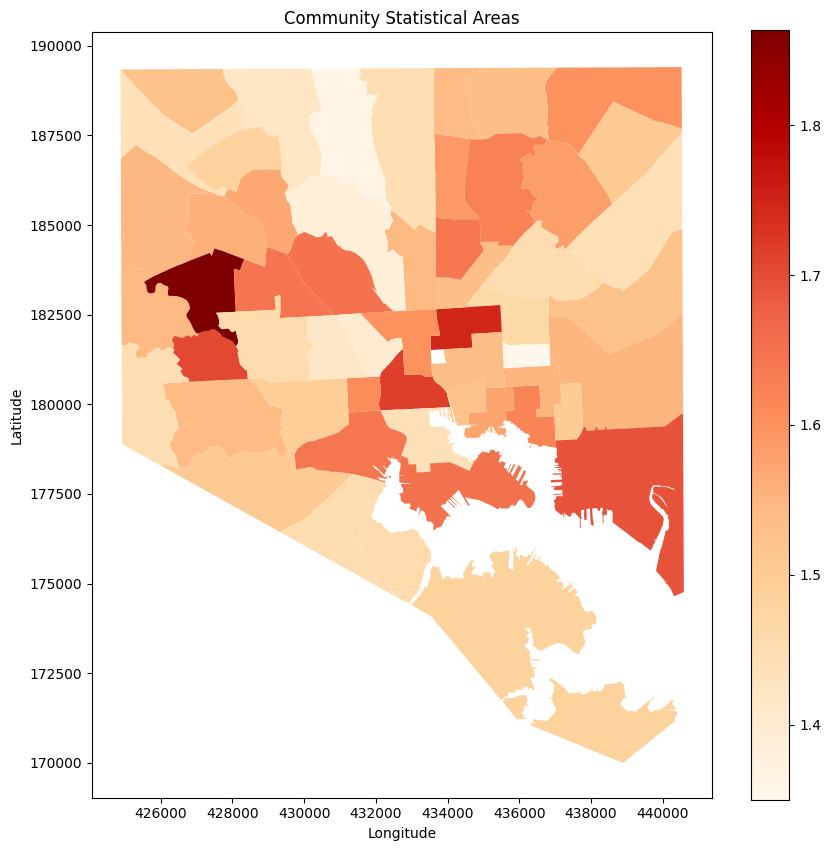

In [42]:
# make a plot of the CSAs
csa_data.plot(column ='priority_score', cmap='OrRd', legend=True, figsize=(10, 10))
plt.title("Community Statistical Areas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()